In [2]:
from get_models import Progress_Bar, Encoder, Decoder, CovarianceMatrix, thermometer_encode_df

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.distributions.normal import Normal
from torchmin import minimize
import scipy.stats as stats
from scipy.stats import chi2, chisquare
from torchmin import minimize
from torch.distributions.multivariate_normal import MultivariateNormal

%load_ext autoreload
%autoreload 2

In [3]:
#vae latent dimension
latent_dim = 1

def get_ind(id, df):
    return np.where(df['patient_id'] == id)[0]

def get_design_matrix(df_effects, fixed_effects_keys, random_effects_keys, r=1, include_interaction=False):
    patient_id = df_effects['patient_id'].unique()

    X_list = [torch.from_numpy(np.array(df_effects.loc[get_ind(id, df_effects), fixed_effects_keys])).to(torch.float32) for id in patient_id]

    if include_interaction==True:
        for key in random_effects_keys[1:]:
            X_list = [torch.cat((X_i, X_i[:,1:] * torch.from_numpy(np.array(df_effects.loc[get_ind(patient_id[j], df_effects), key])).unsqueeze(-1)
                                ), -1).to(torch.float32) for j,X_i in enumerate(X_list)]

    X_list = [torch.cat((torch.from_numpy(np.array(df_effects.loc[get_ind(patient_id[j], df_effects), 'age'])).unsqueeze(-1), X_i), -1).to(torch.float32) for j,X_i in enumerate(X_list)]


    Z_list = [torch.from_numpy(np.array(df_effects.loc[get_ind(id, df_effects), random_effects_keys])).to(torch.float32) for id in patient_id]
    Z_list = [torch.block_diag(*[i for j in range(r)]) for i in Z_list]   
    X_list = [torch.block_diag(*[i for j in range(r)]) for i in X_list]
    return X_list, Z_list



In [4]:
# initialize Encoder and Decoder Models and the Mixed Model Parameters. mode='diagonal': Diagonal Covariance Matrix, mode='full': Full Covariance Matrix,
def initialize(latent_dim, mode='diagonal'):
    encoder = Encoder(
        input_dim=np.shape(test_scores_df_encoded)[-1],
        hidden_dims=[150], # 2-3 layer
        output_dim=latent_dim, 
        act=torch.nn.Tanh())

    decoder = Decoder(
        item_positions=np.concatenate([[i]*a for i,a in enumerate(np.array(test_scores_df[test_scores_df.columns[1:]].max(0)).astype(np.int32))]),                            
        input_dim=latent_dim,
        hidden_dims=[150], 
        act=torch.nn.Tanh())

    var_param = CovarianceMatrix(q*latent_dim, mode=mode)    
    return encoder, decoder, var_param

In [5]:
def likelihood_ratio(L_full, L_red):
    return 2 * (L_full - L_red)

def train_vae(epochs, batch_size, encoder, decoder, optimizer_vae, alpha=1, gamma=1):
    steps = int(len(test_scores_df_encoded) / batch_size)
    rng = np.random.default_rng(1234)
    prior = Normal(torch.zeros(torch.Size([latent_dim])), torch.ones(torch.Size([latent_dim])))
    #progBar = Progress_Bar(epochs, steps, ['nELBO', 'KL', 'Rec Loss', 'Item Error'])

    for epoch in range(epochs):
        shuffle = rng.permutation(len(test_scores_df_encoded))
        
        for step in range(steps):
            pat_batch = np.arange(len(test_scores_df_encoded))[shuffle[step*batch_size:(step+1)*batch_size]]

            test_data = torch.from_numpy(np.array(test_scores_df_encoded.loc[pat_batch])).to(torch.float32)
            test_data_orig = torch.from_numpy(np.array(test_scores_df[test_scores_df.columns[1:]].loc[pat_batch])).to(torch.int32)

            optimizer_vae.zero_grad(set_to_none=True)
            #encode test scores
            mu, log_sig = encoder.encode(test_data)

            #reparametrization trick to get latent variables
            eps = prior.sample(torch.Size([log_sig.size(dim=0)])) 
            z = mu + log_sig.exp() * eps

            #kl divergence
            kl = torch.mean(0.5 * torch.sum(mu.square() + torch.exp(2.0 * log_sig) - 1.0 - (2.0 * log_sig), dim=1))

            rec_loss, probs = decoder(z, test_data_orig)
            nelbo = alpha * kl + gamma * rec_loss

            nelbo.backward()
            optimizer_vae.step()

            #data_pred = torch.stack([torch.argmax(pred, dim=-1) for pred in probs]) 
            # total test item prediction error  
            #item_error = np.mean(np.sum(np.abs(data_pred.detach().numpy() - test_data_orig.T.numpy()), axis=0))
    
    with torch.no_grad():
        mu, log_sig = encoder.encode(torch.from_numpy(np.array(test_scores_df_encoded)).to(torch.float32))
        epsilon = prior.sample(torch.Size([log_sig.size(dim=0)])) 

        z = mu + log_sig.exp() * epsilon
        return z.detach()


def calc_likelihood(var_param, Z_list, X_list, z_list):
    Phi, sigma = var_param() # phi ist Q also Covarianz von zufälligen Effekten und sigma ist R also Covarianz von fehlervektor eps
    N = sum([len(Z_i) for Z_i in Z_list])

    V_list = [Z_i @ Phi @ Z_i.t() + torch.eye(Z_i.size(0)) * sigma for Z_i in Z_list]
    #epsilon = 1e-5  # Regularisierungswert
    #V_inv_list = [(V_i + epsilon * torch.eye(V_i.size(0))).inverse() for V_i in V_list]
    V_inv_list = [V_i.inverse() for V_i in V_list]
    
    Xt_V_inv_X = torch.stack([X_i.t() @ V_i_inv @ X_i for X_i, V_i_inv in zip(X_list, V_inv_list)]).sum(dim=0)
    Xt_V_inv_y = torch.stack([X_i.t() @ V_i_inv @ y_i for X_i, V_i_inv, y_i in zip(X_list, V_inv_list, z_list)]).sum(dim=0)

    #Check if Xt_V_inv_X is invertible. Only needed for mini batching
    
    EBLUE = Xt_V_inv_X.inverse() @ Xt_V_inv_y
    #EBLUP_list = [Phi @ Z_i.t() @ V_i_inv @ (y_i - X_i @ EBLUE) for X_i, Z_i, V_i_inv, y_i in zip(X_list_batch, Z_list_batch, V_inv_list, z_list)]

    residual_list = [y_i - X_i @ EBLUE for y_i, X_i in zip(z_list, X_list)]
    #Mixed model prediction
    #z_pred = torch.cat([X_i @ EBLUE + Z_i @ EBLUP_i for X_i, Z_i, EBLUP_i in zip(X_list_batch, Z_list_batch, EBLUP_list)]).reshape((-1, latent_dim))

    log_det_V = torch.stack([V_i.det().clamp(min=1e-12).log() for V_i in V_list]).sum()
    const = torch.log(torch.tensor(2.0 * torch.pi))
    rt_V_inv_r = torch.stack([r_i.t() @ V_i_inv @ r_i for r_i, V_i_inv in zip(residual_list, V_inv_list)]).sum()

        #negative mixed models likelihood
    nML = 0.5 * (log_det_V + rt_V_inv_r + N * const) #/ N   
         
    return nML 


def train_vae_2(epochs, batch_size, encoder, decoder, optimizer_vae, Z_list, X_list, var_param, alpha=1, gamma=1, eta=1, beta=1):
    steps = int(num_patients / batch_size)
    rng = np.random.default_rng(1234)
    prior = Normal(torch.zeros(torch.Size([latent_dim])), torch.ones(torch.Size([latent_dim])))
    
    for epoch in range(epochs):
        shuffle = rng.permutation(num_patients)
        
        for step in range(steps):
            #draw minibatch
            pat_batch = patients[shuffle[step*batch_size:(step+1)*batch_size]]
            pat_ind_batch = [torch.arange(pat_ind[i],pat_ind[i+1]) for i in pat_batch]
            
            ind_batch = []
            add = 0
            for ind in range(len(pat_ind_batch)):
                len_i = len(pat_ind_batch[ind])
                ind_batch += [torch.arange(add, add + len_i)]
                add += len_i

            Z_list_batch = [Z_list[pat] for pat in pat_batch]
            X_list_batch = [X_list[pat] for pat in pat_batch]
            
            test_data = torch.concatenate([torch.from_numpy(np.array(test_scores_df_encoded.loc[ind])).to(torch.float32) for ind in pat_ind_batch])
            test_data_orig = torch.concatenate([torch.from_numpy(np.array(test_scores_df[test_scores_df.columns[1:]].loc[ind])).to(torch.int32) for ind in pat_ind_batch])
            
            optimizer_vae.zero_grad(set_to_none=True)
            #encode test scores
            mu, log_sig = encoder.encode(test_data)

            #reparametrization trick to get latent variables
            eps = prior.sample(torch.Size([log_sig.size(dim=0)]))
            z = mu + log_sig.exp() * eps
            
            #kl divergence
            kl = torch.mean(0.5 * torch.sum(mu.square() + torch.exp(2.0 * log_sig) - 1.0 - (2.0 * log_sig), dim=1))

            # get the response variable list (latent z)
            z_list = [z[ind].flatten().to(torch.float32) for ind in ind_batch]

            #Mixed model loglikelihood loss. Notation follows https://www.sfu.ca/sasdoc/sashtml/stat/chap41/sect23.htm
            Phi, sigma = var_param()

            V_list = [Z_i @ Phi @ Z_i.t() + torch.eye(Z_i.size(0)) * sigma for Z_i in Z_list_batch]
            V_inv_list = [V_i.inverse() for V_i in V_list]
            
            Xt_V_inv_X = torch.stack([X_i.t() @ V_i_inv @ X_i for X_i, V_i_inv in zip(X_list_batch, V_inv_list)]).sum(dim=0)
            Xt_V_inv_y = torch.stack([X_i.t() @ V_i_inv @ y_i for X_i, V_i_inv, y_i in zip(X_list_batch, V_inv_list, z_list)]).sum(dim=0)

            #Check if Xt_V_inv_X is invertible. Only needed for mini batching
            if torch.abs(torch.det(Xt_V_inv_X)) > 1e-6:
                EBLUE = Xt_V_inv_X.inverse() @ Xt_V_inv_y
                EBLUP_list = [Phi @ Z_i.t() @ V_i_inv @ (y_i - X_i @ EBLUE) for X_i, Z_i, V_i_inv, y_i in zip(X_list_batch, Z_list_batch, V_inv_list, z_list)]
        
                #Mixed model prediction
                z_pred = torch.cat([X_i @ EBLUE + Z_i @ EBLUP_i for X_i, Z_i, EBLUP_i in zip(X_list_batch, Z_list_batch, EBLUP_list)]).reshape((-1, latent_dim))


                #distance between encoder latent variables and mixed model prediction
                residuals = ((z_pred - z) ** 2).sum(1).mean()

                N = sum([len(Z_i) for Z_i in Z_list])
                residual_list = [y_i - X_i @ EBLUE for y_i, X_i in zip(z_list, X_list_batch)]
                log_det_V = torch.stack([V_i.det().clamp(min=1e-12).log() for V_i in V_list]).sum()
                const = torch.log(torch.tensor(2.0 * torch.pi))
                rt_V_inv_r = torch.stack([r_i.t() @ V_i_inv @ r_i for r_i, V_i_inv in zip(residual_list, V_inv_list)]).sum()
                #negative mixed models likelihood
                nML = 0.5 * (log_det_V + rt_V_inv_r + N * const) / N
                # nML = calc_likelihood(var_param, Z_list_batch, X_list_batch, z_list)

                #reconstruction loss
                rec_loss, probs = decoder(z_pred, test_data_orig)

                #loss function
                nelbo = alpha * kl + eta * residuals + gamma * rec_loss + beta * nML
                
                nelbo.backward()
                optimizer_vae.step()    
    
    with torch.no_grad():
        mu, log_sig = encoder.encode(torch.from_numpy(np.array(test_scores_df_encoded)).to(torch.float32))
        epsilon = prior.sample(torch.Size([log_sig.size(dim=0)])) 

        z = mu + log_sig.exp() * epsilon
        return z.detach()


In [20]:
num_simulations = 1000
iterations = 30
lrt_results = []

all_epochs_dict = {} #dictionary to save all models

save_dir = os.path.join(os.getcwd(), 'saved_parameters')
os.makedirs(save_dir, exist_ok=True)

fixed_effects_keys_full = ['family_affected', 'sco_surg', '≤3', 'onset_age', 'presym_diag', 'presymptomatic', 'stand_lost', 'stand_gained', 'stand_never', 'sex']
random_effects_keys_full = ['intercept', 'since_medication', 'since_switch']
# reduced model without fixed effect 'sex' 
fixed_effects_keys_red = ['family_affected', 'sco_surg', '≤3', 'onset_age', 'presym_diag', 'presymptomatic', 'stand_lost', 'stand_gained', 'stand_never']
random_effects_keys_red = ['intercept', 'since_medication', 'since_switch']
q = len(random_effects_keys_full)

for i in range(num_simulations): 
    print(f"Epoch: {i}")
    #prepare dataset
    test_scores_df = pd.read_csv(os.getcwd()+'/test_scores.csv')
    test_scores_df_encoded = thermometer_encode_df(test_scores_df, test_scores_df.columns[1:])
    time_df = pd.read_csv(os.getcwd()+'/time_df.csv')
    time_df['intercept'] = np.ones(time_df.shape[0])
    baseline_df = pd.read_csv(os.getcwd()+'/baseline_df.csv')
    baseline_df['sex'] = np.random.randint(2, size=baseline_df.shape[0])
    df_effects = pd.merge(baseline_df, time_df, on='patient_id', how='inner')

    patients = torch.from_numpy(np.array(baseline_df['patient_id']))
    num_patients = len(patients)

    X_list_full, Z_list_full = get_design_matrix(df_effects, fixed_effects_keys_full, random_effects_keys_full, r=latent_dim)
    X_list_red, Z_list_red = get_design_matrix(df_effects, fixed_effects_keys_red, random_effects_keys_red, r=latent_dim)   
    
    pat_ind = np.cumsum([0]+[int(len(X_i)/latent_dim) for X_i in X_list_full])

    encoder, decoder = initialize(latent_dim)[0:2]
    optimizer_vae = torch.optim.Adam([ 
        {'params': encoder.parameters(), 'lr': 0.01},  
        {'params': decoder.parameters(), 'lr': 0.01},  
    ])  
    z = train_vae(2, 128, encoder, decoder, optimizer_vae)
    pat_ind_b = [torch.arange(pat_ind[i],pat_ind[i+1]) for i in patients]

    for j in range(iterations):
        # print(f"Iteration: {j}")
        if j != 0:
            calc_likelihood(var_param_full, Z_list_full, X_list_full, z_list)
            z = train_vae_2(1, 128, encoder, decoder, optimizer_vae, Z_list_full, X_list_full, var_param_full, alpha=1, gamma=1, eta=10, beta = 10)
        
        z_list = [z[ind].flatten().to(torch.float32) for ind in pat_ind_b]
        
        var_param_full = CovarianceMatrix(q*latent_dim, mode='diagonal')  
        print(var_param_full.parameters())

        optimizer_mm_full = torch.optim.LBFGS([ 
            {'params': var_param_full.parameters(),
            'lr': 0.25, 
            'max_iter':200, 
            'max_eval': 500, 
            'tolerance_grad':1e-09, 
            'tolerance_change':1e-11, 
            'history_size':200}
        ])
        
        def closure():
            optimizer_mm_full.zero_grad()
            res = calc_likelihood(var_param_full, Z_list_full, X_list_full, z_list)
            res.backward()
            return res
        
        optimizer_mm_full.step(closure) 

    var_param_red = CovarianceMatrix(q*latent_dim, mode='diagonal') 
    optimizer_mm_red = torch.optim.LBFGS([ 
        {'params': var_param_red.parameters(),
        'lr': 0.25, 
        'max_iter':200, 
        'max_eval': 500, 
        'tolerance_grad':1e-09, 
        'tolerance_change':1e-11, 
        'history_size':200}
    ])

    def closure_red():
        optimizer_mm_red.zero_grad()
        res = calc_likelihood(var_param_red, Z_list_red, X_list_red, z_list)
        res.backward()
        return res
        
    optimizer_mm_red.step(closure_red)
    
    res_full = calc_likelihood(var_param_full, Z_list_full, X_list_full, z_list)
    res_red = calc_likelihood(var_param_red, Z_list_red, X_list_red, z_list)
    
    lrt_val = likelihood_ratio(res_full, res_red).detach()
    lrt_results.append(lrt_val)

    print(f"\n LRT Value: {lrt_val}")

    all_epochs_dict[f'epoch_{i}'] = {
        'encoder_state_dict': encoder.state_dict(),
        'decoder_state_dict': decoder.state_dict(),
        'var_param_full': var_param_full,
        'optimizer_vae_state_dict': optimizer_vae.state_dict(),
        'var_param_red': var_param_red,
        'optimizer_mm_full': optimizer_mm_full,
        'optimizer_mm_red': optimizer_mm_red,
        'X_list_full' : X_list_full,
        'Z_list_full' : Z_list_full,
        'X_list_red' : X_list_red,
        'Z_list_red' : Z_list_red,
        'z_list': z_list,
        'lrt_val': lrt_val
    }



torch.save(lrt_results, os.path.join(save_dir, 'params_nML_in_lossfkt.pth'))

Epoch: 0
<generator object Module.parameters at 0x0000021F1015AF90>


KeyboardInterrupt: 

In [ ]:
hist = []
for val in lrt_results:
    hist.append(-val)

# plot the histogr<am of the LRT-statistic
plt.hist(hist, bins=50, density=True, alpha=0.6, color='g', label='Histogramm der LRT-Statistik')

# Chi-Quadrat-Verteilung mit zwei Freiheitsgraden plotten (für Vergleich)
x = np.linspace(0, 10, 1000)
plt.plot(x, chi2.pdf(x, 1), 'r-', lw=1, label='Chi-Square distribution (df=1)')


# Beschriftungen hinzufügen
plt.title('Histogramm der Likelihood-Ratio-Teststatistiken')
plt.xlabel('Teststatistik')
plt.ylabel('Häufigkeit')
plt.legend()

# Save the histogram in the current directory
histogram_path = os.path.join(os.getcwd(), 'hist_nML_inLoss.png')
plt.savefig(histogram_path)

# Histogramm anzeigen
plt.show()

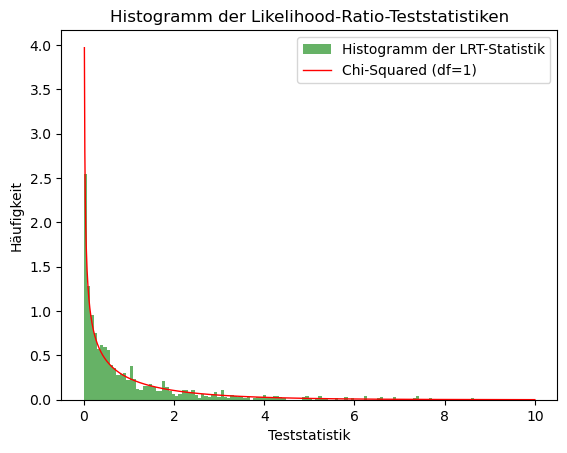

In [11]:
data = np.load('1_lat_dim.npy')
hist_vals = []

for val in data:
    if 10 > val > 0:
        hist_vals.append(val)

# plot the histogr<am of the LRT-statistic
plt.hist(hist_vals, bins=120, density=True, alpha=0.6, color='g', label='Histogramm der LRT-Statistik')

# Chi-Quadrat-Verteilung mit zwei Freiheitsgraden plotten (für Vergleich)
x = np.linspace(0, 10, 1000)
plt.plot(x, chi2.pdf(x, df=1), 'r-', lw=1, label='Chi-Squared (df=1)')


# Beschriftungen hinzufügen
plt.title('Histogramm der Likelihood-Ratio-Teststatistiken')
plt.xlabel('Teststatistik')
plt.ylabel('Häufigkeit')
plt.legend()

# Save the histogram in the current directory
histogram_path = os.path.join(os.getcwd(), 'hist_nML_in_lossfkt.png')
plt.savefig(histogram_path)

# Histogramm anzeigen
plt.show()

Chi-Quadrat-Statistik: 0.05157511461061281
p-Wert: 0.9999999986715986


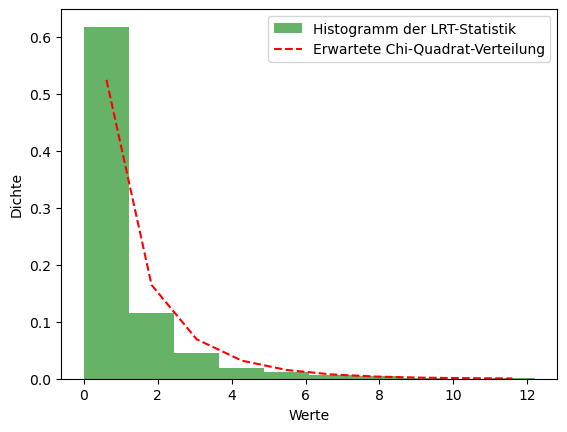

In [17]:
# Daten laden
data = np.load('1_lat_dim.npy')

# Negative Werte aus den Daten entfernen
cleaned_data = data[data >= 0]

# Anzahl der Bins für das Histogramm
num_bins = 10

# Histogramm der Daten erstellen
hist, bin_edges = np.histogram(cleaned_data, bins=num_bins, density=True)

# Mittelpunkte der Bins berechnen
bin_midpoints = 0.5 * (bin_edges[:-1] + bin_edges[1:])

# Erwartete Häufigkeiten anhand der Chi-Quadrat-Verteilung berechnen
expected_freq = stats.chi2.pdf(bin_midpoints, df=1)

# Erwartete Häufigkeiten an die Summe der Histogrammhöhen anpassen
expected_freq = expected_freq * np.sum(hist) / np.sum(expected_freq)

# Chi-Quadrat-Goodness-of-Fit-Test durchführen
chi2_stat, p_value = stats.chisquare(hist, expected_freq)

# Ergebnisse anzeigen
print(f'Chi-Quadrat-Statistik: {chi2_stat}')
print(f'p-Wert: {p_value}')

# Histogramm und erwartete Verteilung plotten
plt.hist(cleaned_data, bins=num_bins, density=True, alpha=0.6, color='g', label='Histogramm der LRT-Statistik')
plt.plot(bin_midpoints, expected_freq, 'r--', label='Erwartete Chi-Quadrat-Verteilung')
plt.xlabel('Werte')
plt.ylabel('Dichte')
plt.legend()
plt.show()